# Clustering Basketball Players
### Roland Zhou & Mohammad Radiyat


## Introduction 
### Goal
In sports, scouting new players is a constant problem that teams must deal with to maintain their competitive advantage. Usually coaches rely on various signals to make scouting decisions, including player physique, performance in college leagues, and their own intuition and prior experience. However, machine learning, specifically clustering, may be able to find solutions to this problem much more efficiently and/or effectively. The intuition behind clustering is that coaches would want their teams to be as well-balanced as possible instead of focusing on one specific kind of player. Ideally clustering would separate players out such that coaches could just pick somewhat evenly from clusters for a well-balanced selection of players. 

The goal of this project, then, is to try to see how effectively we can cluster basketball players into five groups and then make sense of the clustering using various visualizations. Some researchers have tried using Gaussian mixture models [[footballresearch2017](http://www.redalyc.org/pdf/710/71051616004.pdf)] on various sources of player statistics information to cluster players together to determine how to separate different kinds of players most optimally. We will also demonstrate the GMM using Edward, and then modify our model by using a Poisson distribution for some of the player statistics instead of Gaussians. 

### Background
Professional basketball is a 5-on-5 team sport where each player on a team normally takes up a different position. Players aim to put the ball into a basket on opposing sides of the court. Shots made close to the basket are worth 2 points, and shots made from far enough away from the basket are worth 3 points (referred to as 3-pointers). 

Some important player stats that we use are:
* Points scored
* Rebounds - # times a player received the ball off of a missed scoring attempt
* Assists - # times a player passed a ball to another player who scored
* Steals - # times a player took the ball from the opposing team during normal play
* Blocks - # times a player successfully blocked a shot from scoring

The 5 positions that players can occupy are:
* Point guard - usually the team's best passer and ball handler. They focus on assists and steals, and are responsible for leading the team on plays
* Shooting guard - players who focus primarily on shooting, especially 3-pointers. 
* Power forward - prolific scorers able to score close to the basket or through shooting from afar. They rely on strength to guard larger players and athleticism to guard quick players. 
* Small forward - versatile players who are able to do a little bit of everything, including shooting, passing, foul shots, and aggressively scoring close to the basket.
* Center - usually the tallest player, focusing on scoring close to the basket and on rebounds and blocks

![](https://i.pinimg.com/originals/6a/85/28/6a85281a70ff8a6b5391681091a87a11.gif)

Fig 1. Basketball positions

### Data

The data was scraped from [basketball-reference.com](basketball-reference.com). It includes seasonal statistical data from the 1950s until 2017 for each active player. Statistics include those listed above, position, age, team, and a variety of other statistics. 

# Prereqs

In [0]:
!pip install tensorflow==1.6

    100% |████████████████████████████████| 45.9MB 707kB/s 
    100% |████████████████████████████████| 3.1MB 10.6MB/s 
    100% |████████████████████████████████| 890kB 6.4MB/s 
  Running setup.py bdist_wheel for html5lib ... - \ done
  Stored in directory: /root/.cache/pip/wheels/50/ae/f9/d2b189788efcf61d1ee0e36045476735c838898eef1cad6e29
Successfully built html5lib
  Found existing installation: bleach 3.0.2
    Uninstalling bleach-3.0.2:
      Successfully uninstalled bleach-3.0.2
  Found existing installation: tensorboard 1.12.0
    Uninstalling tensorboard-1.12.0:
      Successfully uninstalled tensorboard-1.12.0
  Found existing installation: tensorflow 1.12.0
    Uninstalling tensorflow-1.12.0:
      Successfully uninstalled tensorflow-1.12.0


In [0]:
!pip install edward

    100% |████████████████████████████████| 71kB 3.5MB/s 
  Running setup.py bdist_wheel for edward ... - \ done
  Stored in directory: /root/.cache/pip/wheels/ae/61/0c/1f36f3f0c629d1b7a24d042d2c37015a66c091729c95dd8425
Successfully built edward


In [0]:
from google.colab import auth
auth.authenticate_user()

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 22298 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...


In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# Gaussian Mixture Models


Gaussian Mixture Models (GMMs) are one of the most widely used types of clustering methods. They assume that data points $x_1, x_2...x_n$ are all independent identically distributed data points, and that they come from a mixture density $p(x) = \sum_{k=1}^K \pi_kp_k(x)$ where $p_k(x)$ is the normal probability density function of the observations in group $k$ and the $\pi$s are the probabilities that an observation comes from the $k^{th}$ mixture component. Each of the normal probability distributions has its own mean $\mu_k$ and deviation $\sigma_k$. The $k$-dimensional $\pi$ mixes the Gaussian components and is defined such that $\sum_1^K\pi_k = 1$. 

A GMM posits a fixed number of latent gaussian mixture components onto the data, with learnable local membership probabilities as well as global mixture parameters. While commonly used in social sciences, GMM is also limited by the simplicity that makes it widely applicable. Some of the ways we can improve upon the GMM are determining the number of clusters from the data and improving the expressivity of each mixture distribution (something more complex than a gaussian). The "variational autoencoder" is a generative neural network that meets both these improvements, which is what we'll use afterwards. 

## First Run (raw data, no scaling)

### Modeling

We model our raw data without scaling it using a Gaussian mixture model to get a baseline. We take note of the number of training samples $N$ and number of features $D$. 

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [0]:
x_train = np.array(total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1))
N = x_train.shape[0]
D = x_train.shape[1]
K = 5

For a Gaussian mixture model, the likelihood of a data point $x_n$ is 
> $p(x_n|\pi, \mu, \sigma) = \sum_{k=1}^K\pi_k Normal(x_n|\mu_k, \sigma_k)$

The prior on $\pi$ is defined as 
> $p(\pi) = Dirichlet(\pi|\alpha_k)$ 

where $\alpha = 1$. Each component's mean's prior is defined as 
> $p(\mu_k) = Normal(\mu_k|0, I)$

where the covariance is $I$, or the identity matrix. Lastly, each component's variance's prior is defined as 
>$p(\sigma^2_k) = InverseGamma(\sigma^2_k|a,b)$

where $a$ and $b$ are $D$-length vectors of 1s. 

Then we can define the distribution of the mixture conditional on mixture assignments with a latent variable for the assignments using Edward's ParamMixture class, which takes mixing probabilities, component parameters, and component distributions as inputs. 

In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

### Inference

We use Gibbs sampling to draw from the conditionals of each distribution. We set up empirical random variables to estimate the posterior using the sampling. 

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

ValueError: ignored

Next we run Gibbs sampling using a training loop. 

In [0]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 206s | Acceptance Rate: 1.000


### Criticism

We first look at how well-separated the clusters are by using PCA to reduce the dimensionality of the cluster means to 2 and then using a scatterplot. The clusters seem to be fairly well-separated. 

In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

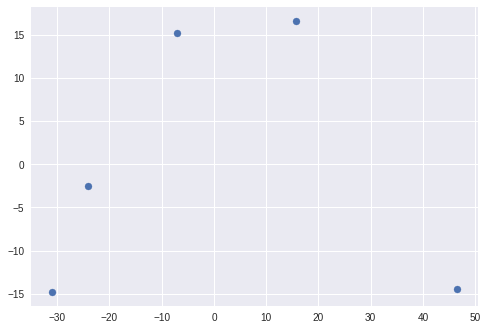

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

Next we plot the log likelihoods of each data point, reduced to two dimensions using PCA. We assign each data point to a the cluster that yields highest likelihood for that point, and plot that. 

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

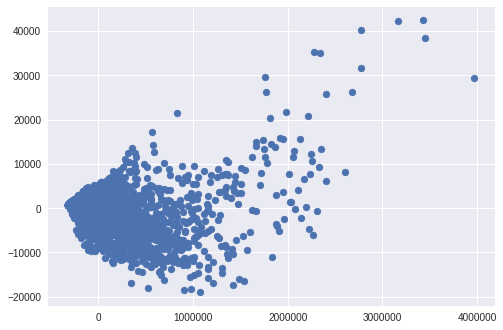

In [0]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

In [0]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

We notice the very strange phenomenon of some of the log likelihoods being greater than 0, which should not happen given that the likelihoods themselves should never surpass 1. We spent a while looking into potential reasons for this, but have found nothing that would suggest that our approach was faulty. 

Next, we count the how many of our training points are in each cluster. 

In [0]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(1, 848), (2, 656), (0, 640), (4, 622), (3, 567)]

One thing that we are interested in is whether clustering separates players by position well, so we count players per position per cluster.

For each player (except for players that appear only once in our data), we count the proportion of times he is placed into each of the 5 clusters, and plot the max of these proportions per player on a histogram. We do this as a check on how confident the clustering is per player. 

Lastly we visualize position/cluster counts on a heatmap. 

In [0]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())


Pos  Cluster
C    0          139
     1          163
     2          151
     3           81
     4          126
PF   0          126
     1          183
     2          144
     3          101
     4          117
PG   0          104
     1          148
     2          139
     3          121
     4          114
SF   0          125
     1          163
     2          102
     3          112
     4          137
SG   0          137
     1          177
     2          114
     3          144
     4          117
dtype: int64


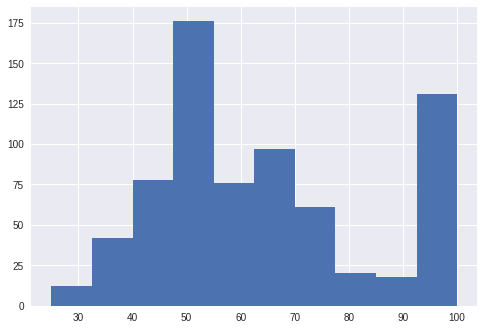

In [0]:
#get dataframe of players and their respective clusters
players = total_csv['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


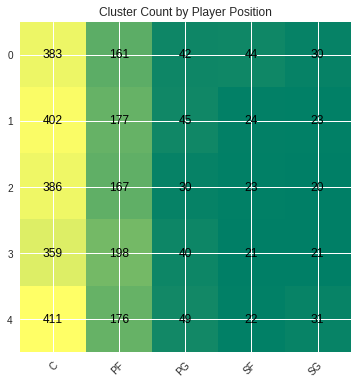

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

The clusters don't seem to separate by position too well; it seems that each cluster has about even numbers of players of each position. 

## Second Run (scaling)

We repeat the above, but by using scikit-learn's StandardScaler to normalize the data. 

### Modeling

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [0]:
x_train = total_csv[total_csv['MP']!=0]

# Standardizing variance across stats
x_train = total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
print(x_train.shape)

N = x_train.shape[0]
D = x_train.shape[1]
K = 5

(3333, 19)


In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

### Inference

As before, we run Gibbs sampling.

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [0]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 205s | Acceptance Rate: 1.000


### Criticism

As before, we check how separated the clusters are by first reducing cluster dimensionality to 2. 

In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

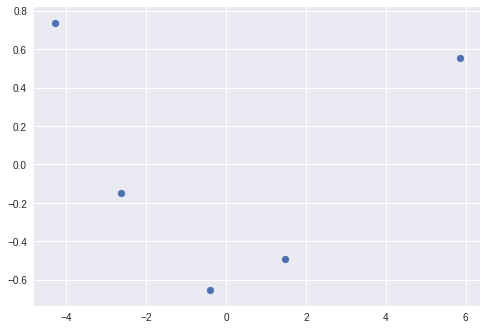

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

The clusters are well-separated this time as well. We look again at the log likelihoods per data point.

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

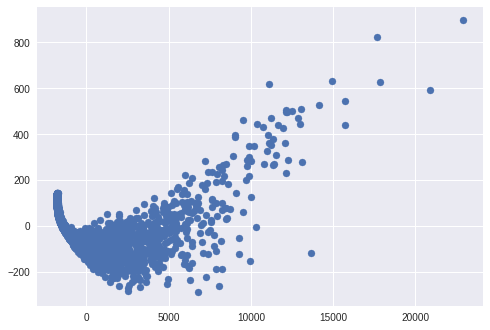

In [0]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

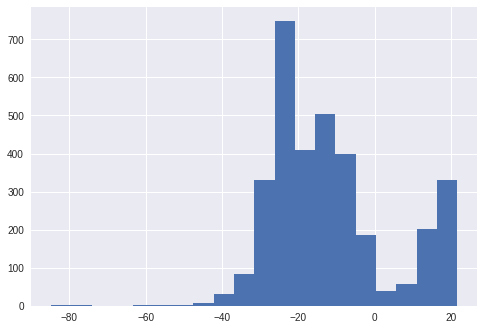

In [0]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

The log-likelihood scatterplot takes a much more interesting shape than before, but we still have the issue of several points having positive log-likelihoods. 

We count number of points per cluster again to make sure that there is at least some level of spread of data points across clusters. 

In [0]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(1, 898), (2, 755), (0, 658), (4, 602), (3, 420)]

As before we look at how each cluster separates positions with a heatmap, and look at how well players are clustered with themselves using a histogram. 

In [0]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())


Pos  Cluster
C    0          140
     1          169
     2          164
     3           62
     4          125
PF   0          126
     1          191
     2          165
     3           72
     4          117
PG   0          107
     1          160
     2          166
     3           84
     4          109
SF   0          135
     1          177
     2          120
     3           80
     4          127
SG   0          141
     1          186
     2          133
     3          116
     4          113
dtype: int64


In [0]:
#get dataframe of players and their respective clusters
players = total_csv['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


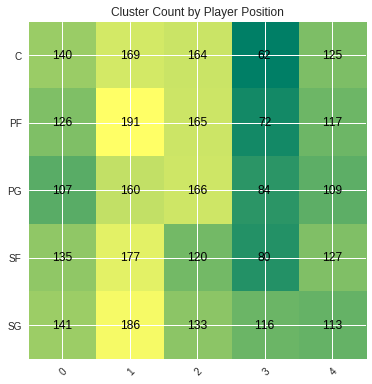

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

With scaled data, cluster 3 does a decent job at picking shooting guards more than other positions, and cluster 1 picks out power forwards and shooting guards better than all other clusters. 

## Third Run (scaling & per-minute stats)

### Modeling

This time, we repeat the analysis but use stats per minute played instead of bulk stats. The data now has signals about player efficiency with respect to time. 

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

Here we divide each player's stats by their total minutes played during the season. 

In [0]:
x_train = total_csv[total_csv['MP']!=0]

for i in ['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']:
  x_train[i] = x_train[i].values / x_train['MP'].values


# Standardizing variance across stats
x_train = total_csv.drop(['Year', 'Player', 'Pos', 'Tm', 'MP'], axis=1)
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
print(x_train.shape)

N = x_train.shape[0]
D = x_train.shape[1]
K = 5

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(3333, 19)


In [0]:
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical

#tf.reset_default_graph()

pi = Dirichlet(tf.ones(K))
mu = Normal(tf.zeros(D), tf.ones(D), sample_shape=K)
sigmasq = InverseGamma(tf.ones(D), tf.ones(D), sample_shape=K)
x = ParamMixture(pi, {'loc': mu, 'scale_diag': tf.sqrt(sigmasq)},
                 MultivariateNormalDiag,
                 sample_shape=N)
z = x.cat

### Inference

We run Gibbs sampling as before. 

In [0]:
T = 500  # number of MCMC samples

qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

In [0]:
inference = ed.Gibbs({pi: qpi, mu: qmu, sigmasq: qsigmasq, z: qz},
                     data={x: x_train})
inference.initialize()

sess = ed.get_session()
tf.global_variables_initializer().run()

t_ph = tf.placeholder(tf.int32, [])
running_cluster_means = tf.reduce_mean(qmu.params[:t_ph], 0)

for _ in range(inference.n_iter):
  info_dict = inference.update()
  inference.print_progress(info_dict)
  t = info_dict['t']
  #if t % inference.n_print == 0:
  #  print("\nInferred cluster means:")
  #  print(sess.run(running_cluster_means, {t_ph: t - 1}))

/usr/local/lib/python3.6/dist-packages/edward/util/random_variables.py:52: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  not np.issubdtype(value.dtype, np.float) and \


500/500 [100%] ██████████████████████████████ Elapsed: 204s | Acceptance Rate: 1.000


### Criticism

We look at the cluster separation as before.

In [0]:
cluster_means = sess.run(running_cluster_means, {t_ph: t - 1})

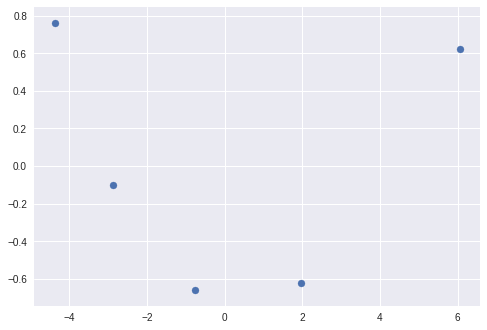

In [0]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2)
stats_transformed = pca_model.fit_transform(cluster_means)
plt.scatter(stats_transformed[:,0], stats_transformed[:, 1])

The clusters are, again, well-separated. We repeat the prior analysis for the log-likelihoods of each of our data points.

In [0]:
# Calculate likelihood for each data point and cluster assignment,
# averaged over many posterior samples. ``x_post`` has shape (N, 100, K, D).
mu_sample = qmu.sample(100)
sigmasq_sample = qsigmasq.sample(100)
x_post = Normal(loc=tf.cast(tf.ones([N, 1, 1, 1]) * mu_sample, tf.float64),
                scale=tf.cast(tf.ones([N, 1, 1, 1]) * tf.sqrt(sigmasq_sample), tf.float64))
x_broadcasted = tf.tile(tf.reshape(x_train, [N, 1, 1, D]), [1, 100, K, 1])

# Sum over latent dimension, then average over posterior samples.
# ``log_liks`` ends up with shape (N, K).
log_liks = x_post.log_prob(x_broadcasted)
log_liks = tf.reduce_sum(log_liks, 3)
log_liks = tf.reduce_mean(log_liks, 1)
#print(log_liks.shape)
#log_liks.eval()[:10]

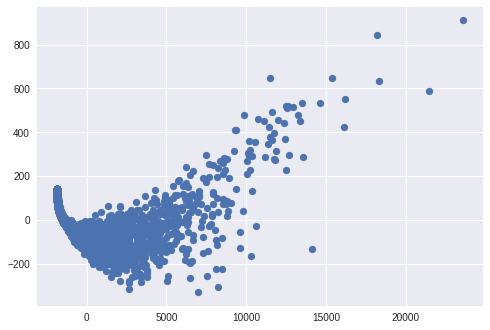

In [0]:
log_ll_values = sess.run(log_liks)

log_ll_values_2d = PCA(n_components=2).fit_transform(log_ll_values)
plt.scatter(log_ll_values_2d[:,0], log_ll_values_2d[:, 1])

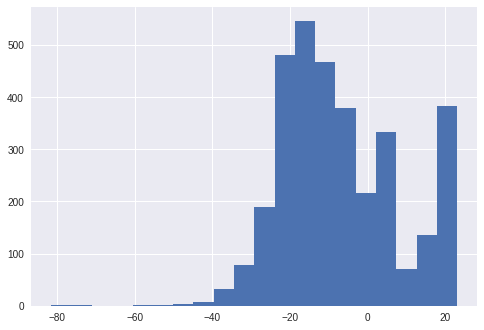

In [0]:
max_log_liks = np.max(log_liks.eval(), 1)

plt.hist(max_log_liks, bins=20)
plt.show()

There are still many points for which the log-likelihood exceeds 0. 

We check membership numbers per cluster again. 

In [0]:
from collections import Counter

clusters = tf.argmax(log_liks, 1).eval()

counts = Counter(clusters)
counts.most_common(5)

[(0, 821), (4, 747), (1, 627), (3, 608), (2, 530)]

Lastly we again look at how each cluster separates positions with a heatmap, and look at how well players are clustered with themselves using a histogram.

In [0]:
positions = total_csv['Pos'].tolist()
pos_clusters = pd.DataFrame(list(zip(positions, clusters)), columns=['Pos', 'Cluster'])
pos_clusters = pos_clusters[pos_clusters['Pos'].isin(['C', 'PF', 'PG', 'SF', 'SG'])]
print(pos_clusters.groupby(['Pos', 'Cluster']).size())

In [0]:
#get dataframe of players and their respective clusters
players = total_csv['Player'].tolist()
player_clusters = pd.DataFrame(list(zip(players, clusters)), columns=['Player', 'Cluster'])

#get rid of players who appear once
player_clusters = player_clusters[player_clusters.groupby('Player').Player.transform(len) > 1]

#get relative frequency of each player's appearance in each cluster
player_clusters = pd.DataFrame(player_clusters.groupby(['Player', 'Cluster']).size())
player_clusters = player_clusters.groupby(['Player', 'Cluster']).agg({0: 'sum'})
player_clusters = player_clusters.groupby(level=0)
player_clusters = pd.DataFrame(player_clusters.apply(lambda x: 100 * x / float(x.sum())))

#only keep the max relative frequency per player; this is a decent gauge of how confidently they can be clustered
player_clusters = pd.DataFrame(player_clusters.groupby('Player').max())

#visualize
player_clusters[0].hist()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  after removing the cwd from sys.path.


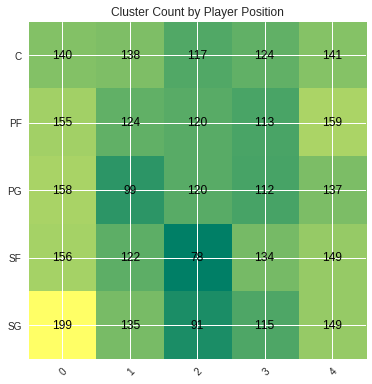

In [0]:
positions = ['C', 'PF', 'PG', 'SF', 'SG']
clusters = list(range(5))

pos_clusters_data = pos_clusters.groupby(['Pos', 'Cluster']).size().reshape([5, 5])


fig, ax = plt.subplots()
im = ax.imshow(pos_clusters_data, cmap = 'summer')

# We want to show all ticks...
ax.set_xticks(np.arange(len(clusters)))
ax.set_yticks(np.arange(len(positions)))
# ... and label them with the respective list entries
ax.set_xticklabels(clusters)
ax.set_yticklabels(positions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(positions)):
    for j in range(len(clusters)):
        text = ax.text(j, i, pos_clusters_data[i, j],
                       ha="center", va="center", color="black")

ax.set_title("Cluster Count by Player Position")
fig.tight_layout()
plt.show()

This time, it looks like cluster 0 does the best in separating out shooting guards among all positions and among all clusters. Cluster 1 has fewest point guards, and cluster 2 has fewest small forwards and shooting guards. 

# VAE

![alt text](http://kvfrans.com/content/images/2016/08/vae.jpg)

The VAE  [[VAE]](https://arxiv.org/abs/1312.6114) assumes a latent variable z generates each of our observed data, x. The VAE itself is then a neural network that is designed to simultaneously learn how to encode x to z and decoding a sampled z to x. It learns how to do so by minimizing the KL divergence between the true posterior $P(z|x)$ and the variational approximation $Q(z|x)$, which is an encoder neural network. However, since we do not have access to the true posterior $P(z|x)$, we opt to equivalently maximize the ELBO, which can be further derived to require only $P(x|z)$ and $P(z)$.

$$KL(q_{ϕ}(z∣x)||p_{θ}(z∣x))$$
$$=E_{q_{ϕ}(z∣x)}[logq_{ϕ}(z∣x)−logp_{θ}(z∣x)]$$
$$=E_{q_{ϕ}(z∣x)}[logq_{ϕ}(z∣x)−logp_{θ}(z,x)]+logp_{θ}(x)$$
$$=KL(q_{ϕ}(z∣x)||p(z))-E_{q_{ϕ}(z∣x)}[logp_{θ}(x|z)]+logp_{θ}(x)$$
$$=−L(x;θ,ϕ)+logp_{θ}(x)$$

Since the VAE learns the function mapping x to its latent z using amortized inference, the VAE can be said to be nonparametric with respect to the parameters of the mixtures. Furthermore, thanks to the flexibility of neural networks, the generative process for x given a latent z can be arbitrarily complex, whereas for a GMM, this generative distribution is simply a multivariate gaussian.

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
import random

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from edward.models import Bernoulli, Normal, Gamma, TransformedDistribution
from edward.util import Progbar

We read in our data.

In [0]:
df = pd.read_csv('drive/player_season_stats.csv', index_col=0)

# Use only recent stats and fill in missing values
df = df[df.Year >= 2011]
df = df.fillna(df.mean())

# Get rid of percentage and advanced derived stats
data_columns = [col for col in df.columns 
                 if not (('%' in col) 
                         or (col in 
                             ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']
                            )
                        )]

# Get rid of minutes played outliers that will inflate totals
total_data = df.drop_duplicates(subset=['Year', 'Player'], keep='first')[data_columns]
total_data = total_data[total_data.MP > 82]

# Standardize on minute and mean/variance
data_columns = ['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
                'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
for c in data_columns:
    total_data[c] = total_data[c].values / total_data['MP'].values

data = total_data.drop(['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP'], axis=1)

We split the data into training and validation data.

In [11]:
# Split out the informational and the actual stat columns
x_cols = data.columns
x_cols_info = ['Year', 'Player', 'Pos', 'Tm']
x_info = total_data[x_cols_info]
x_pos_map = dict((p, i) for i, p in enumerate(x_info.Pos.unique()))

# Scale the data to be between 0 and 1, with some positive noise
scaler = MinMaxScaler()
scaled_xs = scaler.fit_transform(data)
scaled_xs[scaled_xs == 0] += 1e-4

# Mask out some special players for post-predictive checks and add to validation
def get_players(name1, *names):
  mask = x_info.Player == name1
  for name in names:
    mask |= x_info.Player == name
  return scaled_xs[mask], x_info.loc[mask]

special_players, special_players_info = get_players(
    "Stephen Curry", "DeAndre Jordan", "Kobe Bryant"
)

x_train, x_val, x_train_info, x_val_info = train_test_split(scaled_xs, x_info, test_size = 0.2) 

x_val = np.vstack([x_val, special_players])
x_val_info = pd.concat([x_val_info, special_players_info], axis=0)
x_val_colors = list(map(lambda p: x_pos_map[p], x_val_info.Pos))

# Sanity check to see if high scorer is actually high
print(x_info.iloc[np.argmax(data.PTS.values)])

Year                   2017
Player    Russell Westbrook
Pos                      PG
Tm                      OKC
Name: 24654, dtype: object


In [18]:
print(x_train.shape)

(2453, 17)


We define a function to turn our data into batches for our model.

In [0]:
def generator(array, batch_size):
    """Generate batch with respect to array's first axis."""
    n = array.shape[0]
    array = np.copy(array)

    while True:
        start = 0
        stop = start
        while stop < n:
            stop = start + batch_size
            batch = array[start:stop]
            
            yield batch
                
            start = stop
        
        np.random.shuffle(array)

static_batch_size = 100
x_train_generator = generator(x_train, static_batch_size)

It should be noted that VAEs fit on image data typically use binarized image and a Bernoulli likelihood. For colored images, discretization and other custom objectives are used due to instabilities with the MSE objective in neural networks. For our dataset of basketball stats, our data was particularly skewed and we had trouble fitting a VAE using regular Bernoulli and Gaussian likelihoods. We experimented with Gamma and LogNormal likelihoods as well and find that the latter was able to produce the best latent representations.

Below is a visualization of the transformed data and may provide some idea as to why Bernoulli and Gaussians led to instability during training.

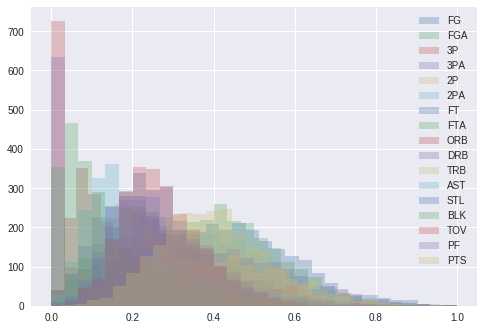

In [13]:
import matplotlib.pyplot as plt

for i, col in enumerate(x_cols):
  plt.hist(x_train[:, i], alpha=0.3, bins=30, label=col)
  plt.legend()
plt.show()

We define a subgraph of the full model, corresponding to a minibatch of size batch_size.

In [0]:
ds = tf.contrib.distributions

N = x_train.shape[0]

hdim1 = 200
hdimz = 5
xdim = x_train.shape[1]
static_batch_size = 100

x_ph = tf.placeholder(tf.float32, [None, xdim])
batch_size = tf.shape(x_ph)[0]
sample_size = tf.placeholder(tf.int32, [])

# Define the generative network from the prior, p(z)
with tf.variable_scope('generative', reuse=tf.AUTO_REUSE):
    z = Normal(loc=tf.zeros([batch_size, hdimz]),
               scale=tf.ones([batch_size, hdimz]))
    
    hidden = tf.layers.dense(z, hdim1, activation=tf.nn.relu, name="dense1")
    hidden = tf.layers.dense(hidden, xdim, name="dense2")
    
    # We construct a LogNormal Distribution, good for fitting right skewed data
    x_pred = TransformedDistribution(
                distribution=ds.Normal(loc=hidden, scale=1.),
                bijector=ds.bijectors.Exp(),
                name="LogNormalTransformedDistribution")

# Define the inference network i.e. q(z | x)
with tf.variable_scope('inference', reuse=tf.AUTO_REUSE):
    hidden = tf.layers.dense(x_ph, hdim1, activation=tf.nn.relu)
    qloc = tf.layers.dense(hidden, hdimz)
    qscale = tf.layers.dense(hidden, hdimz, activation=tf.nn.softplus)
    qz = Normal(loc=qloc, scale=qscale)
    qz_sample = qz.sample(sample_size)

# Define the generative network from the posterior, q(z | x)
with tf.variable_scope('generative'):
    qz_sample = tf.reshape(qz_sample, [-1, hdimz])
    hidden = tf.layers.dense(qz_sample, hdim1, activation=tf.nn.relu, reuse=True, name="dense1")
    hidden = tf.layers.dense(hidden, xdim, reuse=True, name="dense2")
   
    x_gen = tf.exp(hidden)

We bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.

In [0]:
# Enable gradual scaling of the prior regularization to prevent posterior collapse
kl_coef = tf.placeholder(tf.float32, ())

# Bind p(x, z) and q(z | x) to the same TensorFlow placeholder for x.
inference = ed.KLqp({z: qz}, data={x_pred: x_ph})
optimizer = tf.train.RMSPropOptimizer(0.001, epsilon=0.9)
inference.initialize(optimizer=optimizer, 
                     n_samples=10,
                     kl_scaling={z: kl_coef})

# Build elbo loss to evaluate on validation data
elbo_loss, grads = inference.build_loss_and_gradients([])

In [0]:
from sklearn import manifold

def latents_to_2d(z, perplexity=30):
  tsne = manifold.TSNE(n_components=2, 
                       random_state=0,
                       init='random', 
                       learning_rate=15.,
                       perplexity=perplexity)
  z_2d = tsne.fit_transform(z)
  return z_2d

We now minimize the error between our posterior and variational inference approximation to the posterior.

24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 1 | -Training logP(x) <= 17.307502873738606
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 2 | -Training logP(x) <= 7.708882204691569
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 3 | -Training logP(x) <= 4.399023418426514
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 4 | -Training logP(x) <= 3.2992398647467294
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 5 | -Training logP(x) <= 2.9592183208465577
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 6 | -Training logP(x) <= 2.9971402359008787
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 7 | -Training logP(x) <= 2.634255126317342
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 8 | -Training logP(x) <= 2.7350148741404214
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 9 | -Training logP(x) <= 2.4618585749467212
24/24 [100%] ███████████████████████████

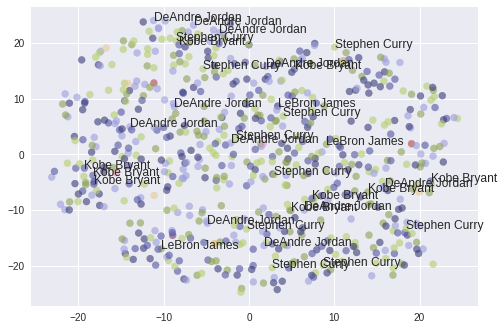

24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 21 | -Training logP(x) <= 2.1882765674591065
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 22 | -Training logP(x) <= 2.0225317811965944
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 23 | -Training logP(x) <= 2.2335489241282147
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 24 | -Training logP(x) <= 1.9541768209139505
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 25 | -Training logP(x) <= 2.053159825007121
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 26 | -Training logP(x) <= 2.048975382844607
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 27 | -Training logP(x) <= 2.137915186882019
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 28 | -Training logP(x) <= 1.9280940727392832
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 29 | -Training logP(x) <= 2.0020148849487303
24/24 [100%] ██████████████████

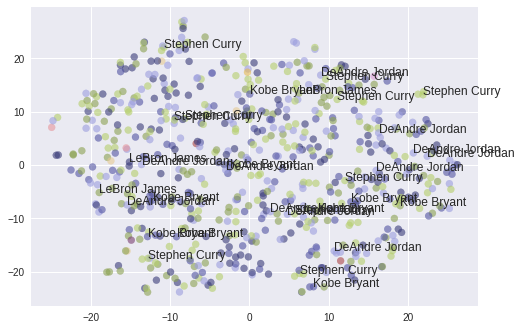

24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 41 | -Training logP(x) <= 1.7102716407179832
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 42 | -Training logP(x) <= 2.2174504788716636
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 43 | -Training logP(x) <= 1.9726123277346292
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 44 | -Training logP(x) <= 2.084892832438151
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 45 | -Training logP(x) <= 2.0483400319019953
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 46 | -Training logP(x) <= 2.01347074508667
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 47 | -Training logP(x) <= 1.926924705505371
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 48 | -Training logP(x) <= 2.1041186745961507
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 49 | -Training logP(x) <= 1.9730529890457789
24/24 [100%] ███████████████████

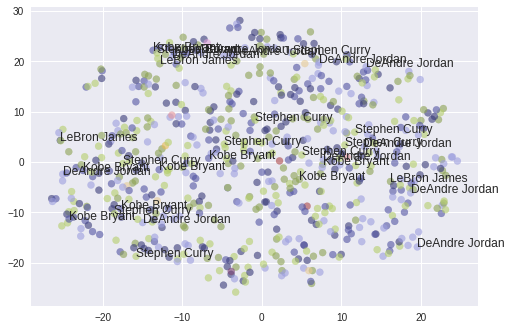

24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 61 | -Training logP(x) <= 1.9668885985016822
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 62 | -Training logP(x) <= 2.060753533045451
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 63 | -Training logP(x) <= 1.9564382807413736
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 64 | -Training logP(x) <= 1.7652914056181908
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 65 | -Training logP(x) <= 2.1947227986653646
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 66 | -Training logP(x) <= 2.081670792897542
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 67 | -Training logP(x) <= 1.9694412271181743
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 68 | -Training logP(x) <= 2.114855758349101
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 69 | -Training logP(x) <= 1.9646141028404236
24/24 [100%] ██████████████████

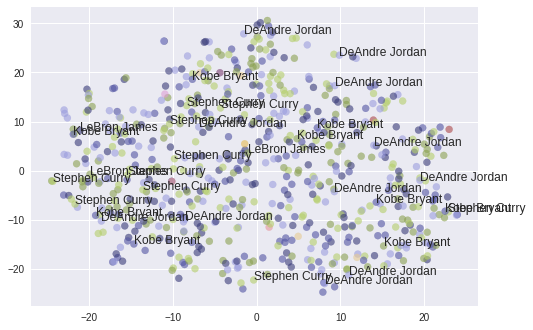

24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 81 | -Training logP(x) <= 2.117406131426493
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 82 | -Training logP(x) <= 2.134528919061025
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 83 | -Training logP(x) <= 1.7896480186780295
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 84 | -Training logP(x) <= 2.027190982500712
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 85 | -Training logP(x) <= 2.1599068450927734
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 86 | -Training logP(x) <= 1.8957341714700062
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 87 | -Training logP(x) <= 1.9290198278427124
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 88 | -Training logP(x) <= 2.172740993499756
24/24 [100%] ██████████████████████████████ Elapsed: 0s
Epoch: 89 | -Training logP(x) <= 2.0443917107582092
24/24 [100%] ███████████████████

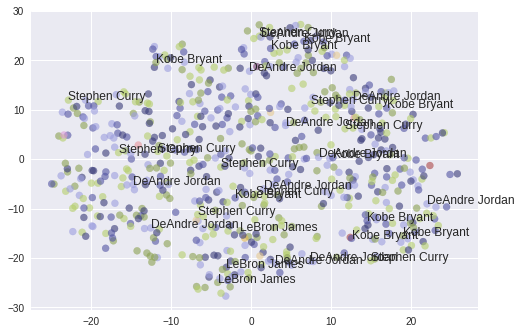

In [17]:
sess = ed.get_session()
tf.global_variables_initializer().run()

n_epochs = 100
n_iter_per_epoch = x_train.shape[0] // static_batch_size
n_iter_validate = 20

for epoch in range(1, n_epochs+1):
  avg_loss = 0.0
  pbar = Progbar(n_iter_per_epoch)
  alpha = min(1., epoch/(n_epochs / 2))
  for t in range(1, n_iter_per_epoch + 1):
    pbar.update(t)
    
    x_batch = next(x_train_generator)
    info_dict = inference.update(
        feed_dict={
            x_ph: x_batch, 
            kl_coef: alpha
        })
    
    avg_loss += info_dict['loss']

  # Print a lower bound to the average marginal likelihood
  avg_loss /= (n_iter_per_epoch * static_batch_size)
  
  print("Epoch: {} | -Training logP(x) <= {}".format(epoch, avg_loss))
  
  # Validation
  if epoch % n_iter_validate == 0:
    n_samples = 20
    val_loss_, z_samples = sess.run([elbo_loss, qz_sample], 
                                    feed_dict={
                                        x_ph: x_val, 
                                        sample_size: n_samples,
                                        kl_coef: max(1., 1./(n_epochs / 2))
                                    })

    print("-Validation logP(x) <= {}".format(val_loss_ / x_val.shape[0]))
    
    # We plot the latent states to see if there is some clustering
    z_2d = latents_to_2d(z_samples[::n_samples])
    plt.scatter(z_2d[:, 0], 
                z_2d[:, 1], 
                c=x_val_colors,
                cmap='tab20b', 
                alpha=0.6)
    
    for player in ['Stephen Curry', 'Kobe Bryant', 'DeAndre Jordan', 'LeBron James']:
      player_mask = x_val_info.Player == player

      for xy in z_2d[player_mask]:
          plt.annotate(player, xy)
    
    plt.show()

# Deep Exponential Family: Sparse Gamma

We next try using a sparse Gamma deep exponential family model [[DEF]](http://www.cs.toronto.edu/~lcharlin/papers/def_aistats.pdf) on our data. 

For each of our data points, $x_n$, we have $L$ layers of hidden variables $\{z_{n,1}. . . z_{n,L}\}$. Also included in the model is a set of $L-1$ layers with weights $\{W_1, W_{L-1}\}$. Each of these is a matrix of independent variables with sparse gamma priors where each weight follows a $Gamma(a,b)$ distribution with $a<1$. The top layer of the latent variables is a vector with each element having a prior $z_{L,k} \sim Gamma (a_L, b_L)$.

The weights and layers are connected through:
> $p(z_{n,l,k} | z_{n,l+1},w_{l,k}) = Gamma(a_1, \frac{a_1}{z^T_{n,l+1}w_{l,k}}) $



We start by reading in our data  and scaling it.

In [0]:
df = pd.read_csv('./data/player_season_stats.csv', index_col=0)

# Use only recent stats and fill in missing values
df = df[df.Year >= 2011]
df = df.fillna(df.mean())

# Get rid of percentage and advanced derived stats
data_columns = [col for col in df.columns 
                 if not (('%' in col) 
                         or (col in 
                             ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']
                            )
                        )]

total_data = df.drop_duplicates(subset=['Year', 'Player'], keep='first')[data_columns]
total_data = total_data[total_data.MP > 0]

# Standardize on minute and mean/variance
data_columns = ['FG', 'FGA', '3P', '3PA', '2P', '2PA', 'FT', 'FTA',
                'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS']
for c in data_columns:
    total_data[c] = total_data[c].values / total_data['MP'].values

data = total_data.drop(['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP'], axis=1)
data = StandardScaler(with_mean=False).fit_transform(data)

# Add small positive noise so that Gamma distribution support is met
noise = 1e-4
data += noise

We define our deep exponential family as above using 3 layers. We use default values of 0.1 for the scale and shape parameters of our Gamma distributions. 

In [0]:
from edward.models import Gamma, Poisson
from edward.util import Progbar
from utils import pointmass_q, gamma_q

def pointmass_q(shape, name=None):
  with tf.variable_scope(name, default_name="pointmass_q"):
    min_mean = 1e-3
    mean = tf.get_variable("mean", shape)
    rv = PointMass(tf.maximum(tf.nn.softplus(mean), min_mean))
    return rv

def gamma_q(shape, name=None):
  # Parameterize Gamma q's via shape and scale, with softplus unconstraints.
  with tf.variable_scope(name, default_name="gamma_q"):
    min_shape = 1e-3
    min_scale = 1e-5
    shape_var = tf.get_variable(
        "shape", shape,
        initializer=tf.random_normal_initializer(mean=0.5, stddev=0.1))
    scale_var = tf.get_variable(
        "scale", shape, 
        initializer=tf.random_normal_initializer(stddev=0.1))
    rv = Gamma(tf.maximum(tf.nn.softplus(shape_var), min_shape),
               tf.maximum(1.0 / tf.nn.softplus(scale_var), 1.0 / min_scale))
    return rv

scale = 0.1
shape = 0.1

z_shape = 0.1

K = [20, 20, 20]
D = data.shape[1]
N = data.shape[0]

x_ph = tf.placeholder(tf.float32, [N, D])

w2 = Gamma(scale, shape, sample_shape=[K[2], K[1]])
w1 = Gamma(scale, shape, sample_shape=[K[1], K[0]])
w0 = Gamma(scale, shape, sample_shape=[K[0], D])

z3 = Gamma(scale, shape, sample_shape=[N, K[2]])
z2 = Gamma(z_shape, z_shape / tf.matmul(z3, w2))
z1 = Gamma(z_shape, z_shape / tf.matmul(z2, w1))
x = Gamma(z_shape, z_shape / tf.matmul(z1, w0))

qw2 = pointmass_q(w2.shape)
qw1 = pointmass_q(w1.shape)
qw0 = pointmass_q(w0.shape)

qz3 = gamma_q(z3.shape)
qz2 = gamma_q(z2.shape)
qz1 = gamma_q(z1.shape)

lr = 0.001

Next we run variational inference:

In [0]:
inference_e = ed.KLqp({z1: qz1, z2: qz2, z3: qz3},
                      data={x: data, w2: qw2, w1: qw1, w0: qw0})
inference_m = ed.MAP({w2: qw2, w1: qw1, w0: qw0},
                     data={x: data, z3: qz3, z2: qz2, z1: qz1})
optimizer_e = tf.train.RMSPropOptimizer(lr)
optimizer_m = tf.train.RMSPropOptimizer(lr)

kwargs_e = dict(
    optimizer=optimizer_e,
    n_print=100
)

inference_e.initialize(**kwargs_e)
inference_m.initialize(optimizer=optimizer_m)

n_epoch = 20
n_iter_per_epoch = 1000
n_iter_per_check = 100

sess = ed.get_session()
tf.global_variables_initializer().run()

for epoch in range(n_epoch):
    print("Epoch {}".format(epoch))
    train_ll = 0.
    
    pbar = Progbar(n_iter_per_epoch)
    for t in range(1, n_iter_per_epoch+1):
        pbar.update(t)
        info_dict_e = inference_e.update()
        info_dict_m = inference_m.update()
    
        if t % n_iter_per_check == 0:
            batch_ll = sess.run(x.log_prob(x_ph), feed_dict={x_ph: data}) 
            train_ll += np.sum(batch_ll)
    
    train_ll /= (n_iter_per_epoch / n_iter_per_check)
    print("Log-likelihood at epoch {}: {}".format(epoch, train_ll))

 # Poisson

Restart kernel and start from here for the next iteration of Box's loop

In [0]:
import edward as ed
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

In [0]:
csv = pd.read_csv('drive/player_season_stats.csv', index_col = 0)
csv = csv[csv.Year>=2011]
csv = csv.fillna(csv.mean())
count_columns = [col for col in csv.columns if not (('%' in col) or (col in ['PER', 'Age', 'OWS', 'DWS', 'WS', 'WS/48', 'BPM', 'VORP', '3PAr', 'FTr']))]
count_csv = csv[count_columns]
total_csv = csv.drop_duplicates(subset = ['Year', 'Player'], keep='first')[count_columns]

In [0]:
x_train = total_csv[total_csv['MP']!=0]
N = x_train.shape[0]
D = x_train.shape[1]
K = 5

Index(['Year', 'Player', 'Pos', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'ORB', 'DRB', 'TRB', 'AST', 'STL',
       'BLK', 'TOV', 'PF', 'PTS'],
      dtype='object')

In [0]:
#Redefine model here to use Poissons and multivariate normals
from edward.models import Dirichlet, InverseGamma, MultivariateNormalDiag, \
    Normal, ParamMixture, Empirical, Poisson, Independent

#tf.reset_default_graph()

x_pois_data = x_train[['ORB', 'DRB', 'AST', 'STL', 'BLK']]

x_norm_data = x_train[['G', 'GS', 'MP', 'FG', 'FGA', '3P',
       '3PA', '2P', '2PA', 'FT', 'FTA', 'TOV', 'PF', 'PTS']]

d_normal = x_norm_data.shape[1]
d_poisson = x_pois_data.shape[1]

pi = Dirichlet(tf.ones(K))
mu_normal = Normal(tf.zeros(d_normal), tf.ones(d_normal), sample_shape=K)
sigmasq_normal = InverseGamma(tf.ones(d_normal), tf.ones(d_normal), sample_shape=K)

rate_poisson = InverseGamma(tf.zeros(d_poisson), tf.ones(d_poisson), sample_shape=K)

x_normal = ParamMixture(pi, {'loc': mu_normal, 'scale_diag': tf.sqrt(sigmasq_normal)},
                        MultivariateNormalDiag,
                        sample_shape=N)
z = x.cat

# Attempt at mixture of MV poissons



qpi = Empirical(tf.get_variable(
    "qpi/params", [T, K],
    initializer=tf.constant_initializer(1.0 / K)))
qmu = Empirical(tf.get_variable(
    "qmu/params", [T, K, D],
    initializer=tf.zeros_initializer()))
qsigmasq = Empirical(tf.get_variable(
    "qsigmasq/params", [T, K, D],
    initializer=tf.ones_initializer()))
qz = Empirical(tf.get_variable(
    "qz/params", [T, N],
    initializer=tf.zeros_initializer(),
    dtype=tf.int32))

# References
1. [[footballresearch2017](http://www.redalyc.org/pdf/710/71051616004.pdf)] Soto-Valero, César. "A Gaussian mixture clustering model for characterizing football players using
the EA Sports' FIFA video game system.""  Revista Internacional de Ciencias del Deporte, July 2017, Pages 244-259.

2. [[VAE]](https://arxiv.org/abs/1312.6114) Kingma, Diederik P., and Max Welling. "Auto-encoding variational bayes." arXiv preprint arXiv:1312.6114 (2013).

3. [[DEF]](http://www.cs.toronto.edu/~lcharlin/papers/def_aistats.pdf) Ranganath, Rajesh et al. "Deep Exponential Families." arXiv preprint arXiv:1411.2581 (2014).